In [1]:
# Импорт библиотек
import os
import time

import GTU
import KU_TU
import mat_properties as prop
import numpy as n
import pandas as pd
import SP
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel("streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)
############################################################
# Теплосеть и перекидка температуры воздуха
gas_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
water_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWIN", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SWOUT", "T"] = SP.Tset(Tnv)[0]
water_streams.at["SWIN-TURB", "T"] = water_streams.at["SWIN", "T"]
water_streams.at["SWIN-TURB", "G"] = water_streams.at["SWIN", "G"]
water_streams.at["SP2-WOUT", "T"] = water_streams.at["SWOUT", "T"]
# Qsw=(SP.Tset(Tnv)[0]-SP.Tset(Tnv)[1])*water_streams.at["SWIN", "G"]*4.187/1000
# print("tair",GTU_input.loc["tair", 1])
# print("t1",SP.Tset(Tnv)[1],"t2",SP.Tset(Tnv)[0])
# print("Qsw",Qsw)
############################################################


# Основные эффективности оборудования
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.99


# Параметры, отвечающие за процесс расчета
Calcmethod = "hybr"
Calctolerance = 10**-2
Maxiterations_KU_TU = 15
Maxiterations_cotel = 5
Maxiterations_turbine = 15

# Параметры режима работы ПГУ
# Расчет для минимума нагрузки
Сalculate_minimum = True
# Расчет для работы с теплофикацией
Teplo = int(True)
# Отбор пара высокго давления или доля или кг/с
steamVD_fraction_to_turbine = 1


# Состав газов в номинале в ГТУ
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = list(gas_streams0.loc["GTU-PEVD", "N2":"Ar"])
gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

#####################
######Максимов#######
fractionwaterMethane = (0.833372660622383, 0.166627339377617, 0, 0, 0)
waterMethanemix = "Water*METHANE"

waterMethane = prop.Materials_prop(
    waterMethanemix,
    fractionwaterMethane,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
Methane = prop.Materials_prop(
    "METHANE",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
gas_KU_PKM = prop.Materials_prop(
    gasmix,
    (
        0.710320591016015,
        0.00996710270335893,
        0.090538556815177,
        0.180531273012258,
        0.00864247645319178,
    ),
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Вкл выкл заряд по ПКМ
PKM_zaryad = False
#####################


# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))


gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

############################################################
# Задание ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, "GTU-KU")

# Расчет всей ПГУ вместе


def calculate_CCGT(
    Iterations_KU_TU,
    Iterations_cotel,
    Iterations_turbine,
):

    # Расчет ГТУ
    Gas_turbine_res = Gas_turbine.calc(GTU_input)

    # Запись данных об электричестве
    electric.at["GTU", "N"] = Gas_turbine_res["N"]
    electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
    electric.at["DK", "N"] = Gas_turbine_res["Ndk"]

    # Запись данных о газе на выходе из ГТУ
    gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
    gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
    gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
    gas_streams.at["GTU-KU", "P"] = 0.1
    gas_streams.at["GTU-KU", "H"] = gas0.p_t(
        gas_streams.at["GTU-KU", "P"], gas_streams.at["GTU-KU", "T"]
    )["h"]
    Gas_turbine_composition = pd.read_excel(
        "input.xlsx", sheet_name="Gas_composition0", index_col=0
    )

    # пкм
    ######Максимов#######
    if PKM_zaryad == True:

        steamVD_to_turbine = 0.25 * water_streams0.at["PEVD-DROSVD", "G"]  # !!!максимов
        from PKM import steam_transformer

        # Пар в паротрансформатор
        water_streams.loc["DROSVD-ST", "T":"H"] = water_streams.loc[
            "PEVD-DROSVD", "T":"H"
        ]
        water_streams.loc["DROSVD-ST", "G"] = (
            water_streams.at["PEVD-DROSVD", "G"] - steamVD_to_turbine
        )  # !!!!
        # паротрансформатор
        ST = steam_transformer(
            stream11="DROSVD-ST",
            water=water,
            water_streams=water_streams,
            heaters=heaters,
            Pdr1=2,
            Pdr2=0.8,
            P2=2,
            dT=15,
            dTmin=5,
            Tdec=10,
        )
        steam_trans = ST.calc()

        # Ввод в табл выходов из паротрансформатора
        water_streams.loc["ST-GPK", "T":"G"] = [
            steam_trans["T17"],
            steam_trans["P17"],
            steam_trans["H17"],
            steam_trans["G1"],
        ]
        water_streams.loc["ST-PKM", "T":"G"] = [
            steam_trans["T24"],
            steam_trans["P2"],
            steam_trans["H24"],
            steam_trans["G2"],
        ]
        heaters.at["Strans", "Qw"] = steam_trans["Q"]
        heaters.at["Strans_Qcool", "Qw"] = steam_trans["Qcool80"]

        print(heaters.at["Strans_Qcool", "Qw"])
        # реформер
        from PKM import reformer

        ref = reformer(
            stream11="ST-PKM",
            water=water,
            gas_KU=gas_KU_PKM,
            Methane=Methane,
            waterMethane=waterMethane,
            water_streams=water_streams,
            heaters=heaters,
            Tref=700,
            Pref=2,
            T1gas=1968.58395330148,
            T2gas=800,
        )
        reform = ref.calc()
        # Газы реформера
        gas_streams.loc["AIR-REF", "T":"G"] = [15, 0.1, 414.38, reform["Gair"]]
        gas_streams.loc["CH4-REF", "T":"G"] = [15, 0.7, 881.50, reform["Gch4"]]
        gas_streams.loc["REF-SMESH", "T":"G"] = [
            800,
            0.1,
            reform["H2gas"],
            reform["Ggas"],
        ]
        gas_streams.loc["REF-SMESH", "N2":"Ar"] = list(reform["Gasfrac"].values())

        # Смешение
        gas_streams.loc["GTU-PEVD", "G"] = (
            gas_streams.at["REF-SMESH", "G"] + gas_streams.at["GTU-KU", "G"]
        )
        gas_streams.loc["GTU-PEVD", "H"] = (
            gas_streams.at["REF-SMESH", "G"] * gas_streams.at["REF-SMESH", "H"]
            + gas_streams.at["GTU-KU", "G"] * gas_streams.at["GTU-KU", "H"]
        ) / gas_streams.loc["GTU-PEVD", "G"]
        gas_streams.loc["GTU-PEVD", "P"] = 0.1

        from PKM import mixing_gases_molar

        mixing_gases_molar("GTU-KU", "REF-SMESH", "GTU-PEVD", gas_streams)
        for stream in gas_streams.index[4:10]:
            gas_streams.loc[stream, "N2":"Ar"] = gas_streams.loc["GTU-PEVD", "N2":"Ar"]
    else:
        gas_streams.loc["GTU-PEVD", "T":"Ar"] = gas_streams.loc["GTU-KU", "T":"Ar"]
        water_streams.loc["ST-GPK", "T":"G"] = [80, 2, 320, 0]
        steamVD_to_turbine = 0

    #     # Параметры газа на входе в КУ
    #     gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
    #     gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
    #     gas_streams.loc["GTU-PEVD", "N2":"Ar"] = Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

    # Состав газов при частичной нагрузке
    fractiongas = list(gas_streams.loc["GTU-PEVD", "N2":"Ar"])

    gas1 = prop.Materials_prop(
        gasmix,
        fractiongas,
        prop.REFPROP_h_s,
        prop.REFPROP_p_t,
        prop.REFPROP_p_h,
        prop.REFPROP_p_s,
        prop.REFPROP_p_q,
        prop.REFPROP_t_q,
        prop.REFPROP_p_rho,
        prop.REFPROP_s_q,
        RP=RP,
    )

    # Инициализаця KU+TU, она здесь потому что нжно менять состав газа на входе в КУ

    KU_and_TU = KU_TU.ku_tu(
        gas0,
        gas1,
        water,
        gas_streams0,
        gas_streams,
        water_streams0,
        water_streams,
        heaters,
        electric,
        "PEVD-DROSVD",
        "PPND-DROSND",
        "DROSVD-TURBVD",
        "DROSND-TURBND",
        Calcmethod,
        KPD_SP,
        KPD_KN,
        KPD_to,
        KPD_PN,
        steamVD_fraction_to_turbine,
        steamVD_to_turbine,
    )

    start_time = time.time()

    # Расчет КУ и ТУ
    KU_and_TU.calculate(
        Teplo,
        Calctolerance,
        Iterations_KU_TU,
        Iterations_cotel,
        Iterations_turbine,
    )

    print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")


calculate_CCGT(Maxiterations_KU_TU, Maxiterations_cotel, Maxiterations_turbine)

Время 1 итерации расчета КУ+ТУ:---  8.4 сек. ---
Достигнуто максимальное количество итераций давления верхнего отбора
Diafragma_it [0.01161431665845215, 0.011968486302832908, 0.012149761226092742, 0.011929014001884241]
Погрешность давления в верхнем сетевом отборе в %:  0.662
Время 2 итерации расчета КУ+ТУ:---  43.0 сек. ---
Время 3 итерации расчета КУ+ТУ:---  60.1 сек. ---
Достигнуто максимальное количество итераций давления верхнего отбора
Diafragma_it [0.01579876645477451, 0.013899320578008835, 0.012419668079876182, 0.013046303464794401]
Погрешность давления в верхнем сетевом отборе в %:  -1.88
Достигнуто максимальное количество итераций давления верхнего отбора
Diafragma_it [0.014394088143528246, 0.01472065090951478, 0.014289929668719512, 0.013684644260641364]
Погрешность давления в верхнем сетевом отборе в %:  1.816
Время 4 итерации расчета КУ+ТУ:---  112.3 сек. ---
Время 5 итерации расчета КУ+ТУ:---  145.1 сек. ---
Время 6 итерации расчета КУ+ТУ:---  170.7 сек. ---
Достигнуто мак

In [2]:
Qsw = heaters.at["SP2", "Qw"] + heaters.at["SP1", "Qw"] + heaters.at["OD", "Qw"]
Qsw

167.38833194690247

In [3]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,5.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.1,0.1,958.869199,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,NaN,NaN,NaN,503.8,NaN,NaN,NaN,NaN,NaN
PEVD-IVD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IVD-EVD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVD-PPND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PPND-IND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IND-GPK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPK-out,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,5.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,507.289716,8.387119,3412.985471,63.474651,NaN,NaN
IVD-PEVD,301.151557,8.728101,2747.393162,63.474651,NaN,NaN
EVD-IVD,299.175294,8.728101,1340.111374,63.474651,NaN,NaN
PEN-EVD,163.870839,8.728101,696.945419,63.474651,NaN,NaN
BND-PEN,162.403378,0.656957,685.924203,63.474651,NaN,NaN
PPND-DROSND,175.731366,0.650565,2792.754688,15.589022,NaN,NaN
IND-PPND,162.403378,0.656957,2760.055139,15.589022,NaN,NaN
GPK-IND,159.081259,0.656957,671.514391,79.063673,NaN,NaN
GPK-REC,159.081259,0.656957,671.514391,93.214816,NaN,NaN


In [5]:
# Errors_water = abs(water_streams - water_streams0) / water_streams0 * 100
# Errors_gas = abs(gas_streams - gas_streams0) / gas_streams0 * 100
# Errors_gas
# Errors_water

In [6]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,-9999.990000,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065


In [7]:
electric

,Ni,N,KPDm,KPD
PEN,0.699568,0.715981,0.977076,0.807400
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,159.786600,NaN,33.830242
DK,NaN,6.288919,NaN,NaN
Turbine,58.150455,NaN,NaN,NaN
Tots1,37.444256,NaN,NaN,0.848296
Tots2,15.101065,NaN,NaN,0.696370
Tots3,5.302978,NaN,NaN,0.649420
Tots4,0.302155,NaN,NaN,0.188593


In [8]:
heaters

,Qw,Qg,KPD
PEVD,42251.820568,42678.606634,0.99
IVD,89327.562911,90229.861526,0.99
EVD,40824.842537,41237.214684,0.99
PPND,509.810979,514.960584,0.99
IND,33470.887019,33808.976787,0.99
GPK,39131.497450,39526.765101,0.99
SP2,83.901722,NaN,0.99
SP1,76.679975,NaN,0.99
OD,6.806634,NaN,0.99
Strans,NaN,NaN,NaN


In [9]:
GTU_input

,1,2,3,4,5,6
tair,5,NaN,NaN,NaN,NaN,NaN
n,1,NaN,NaN,NaN,NaN,NaN
Pin,0,NaN,NaN,NaN,NaN,NaN
Pout,0,NaN,NaN,NaN,NaN,NaN


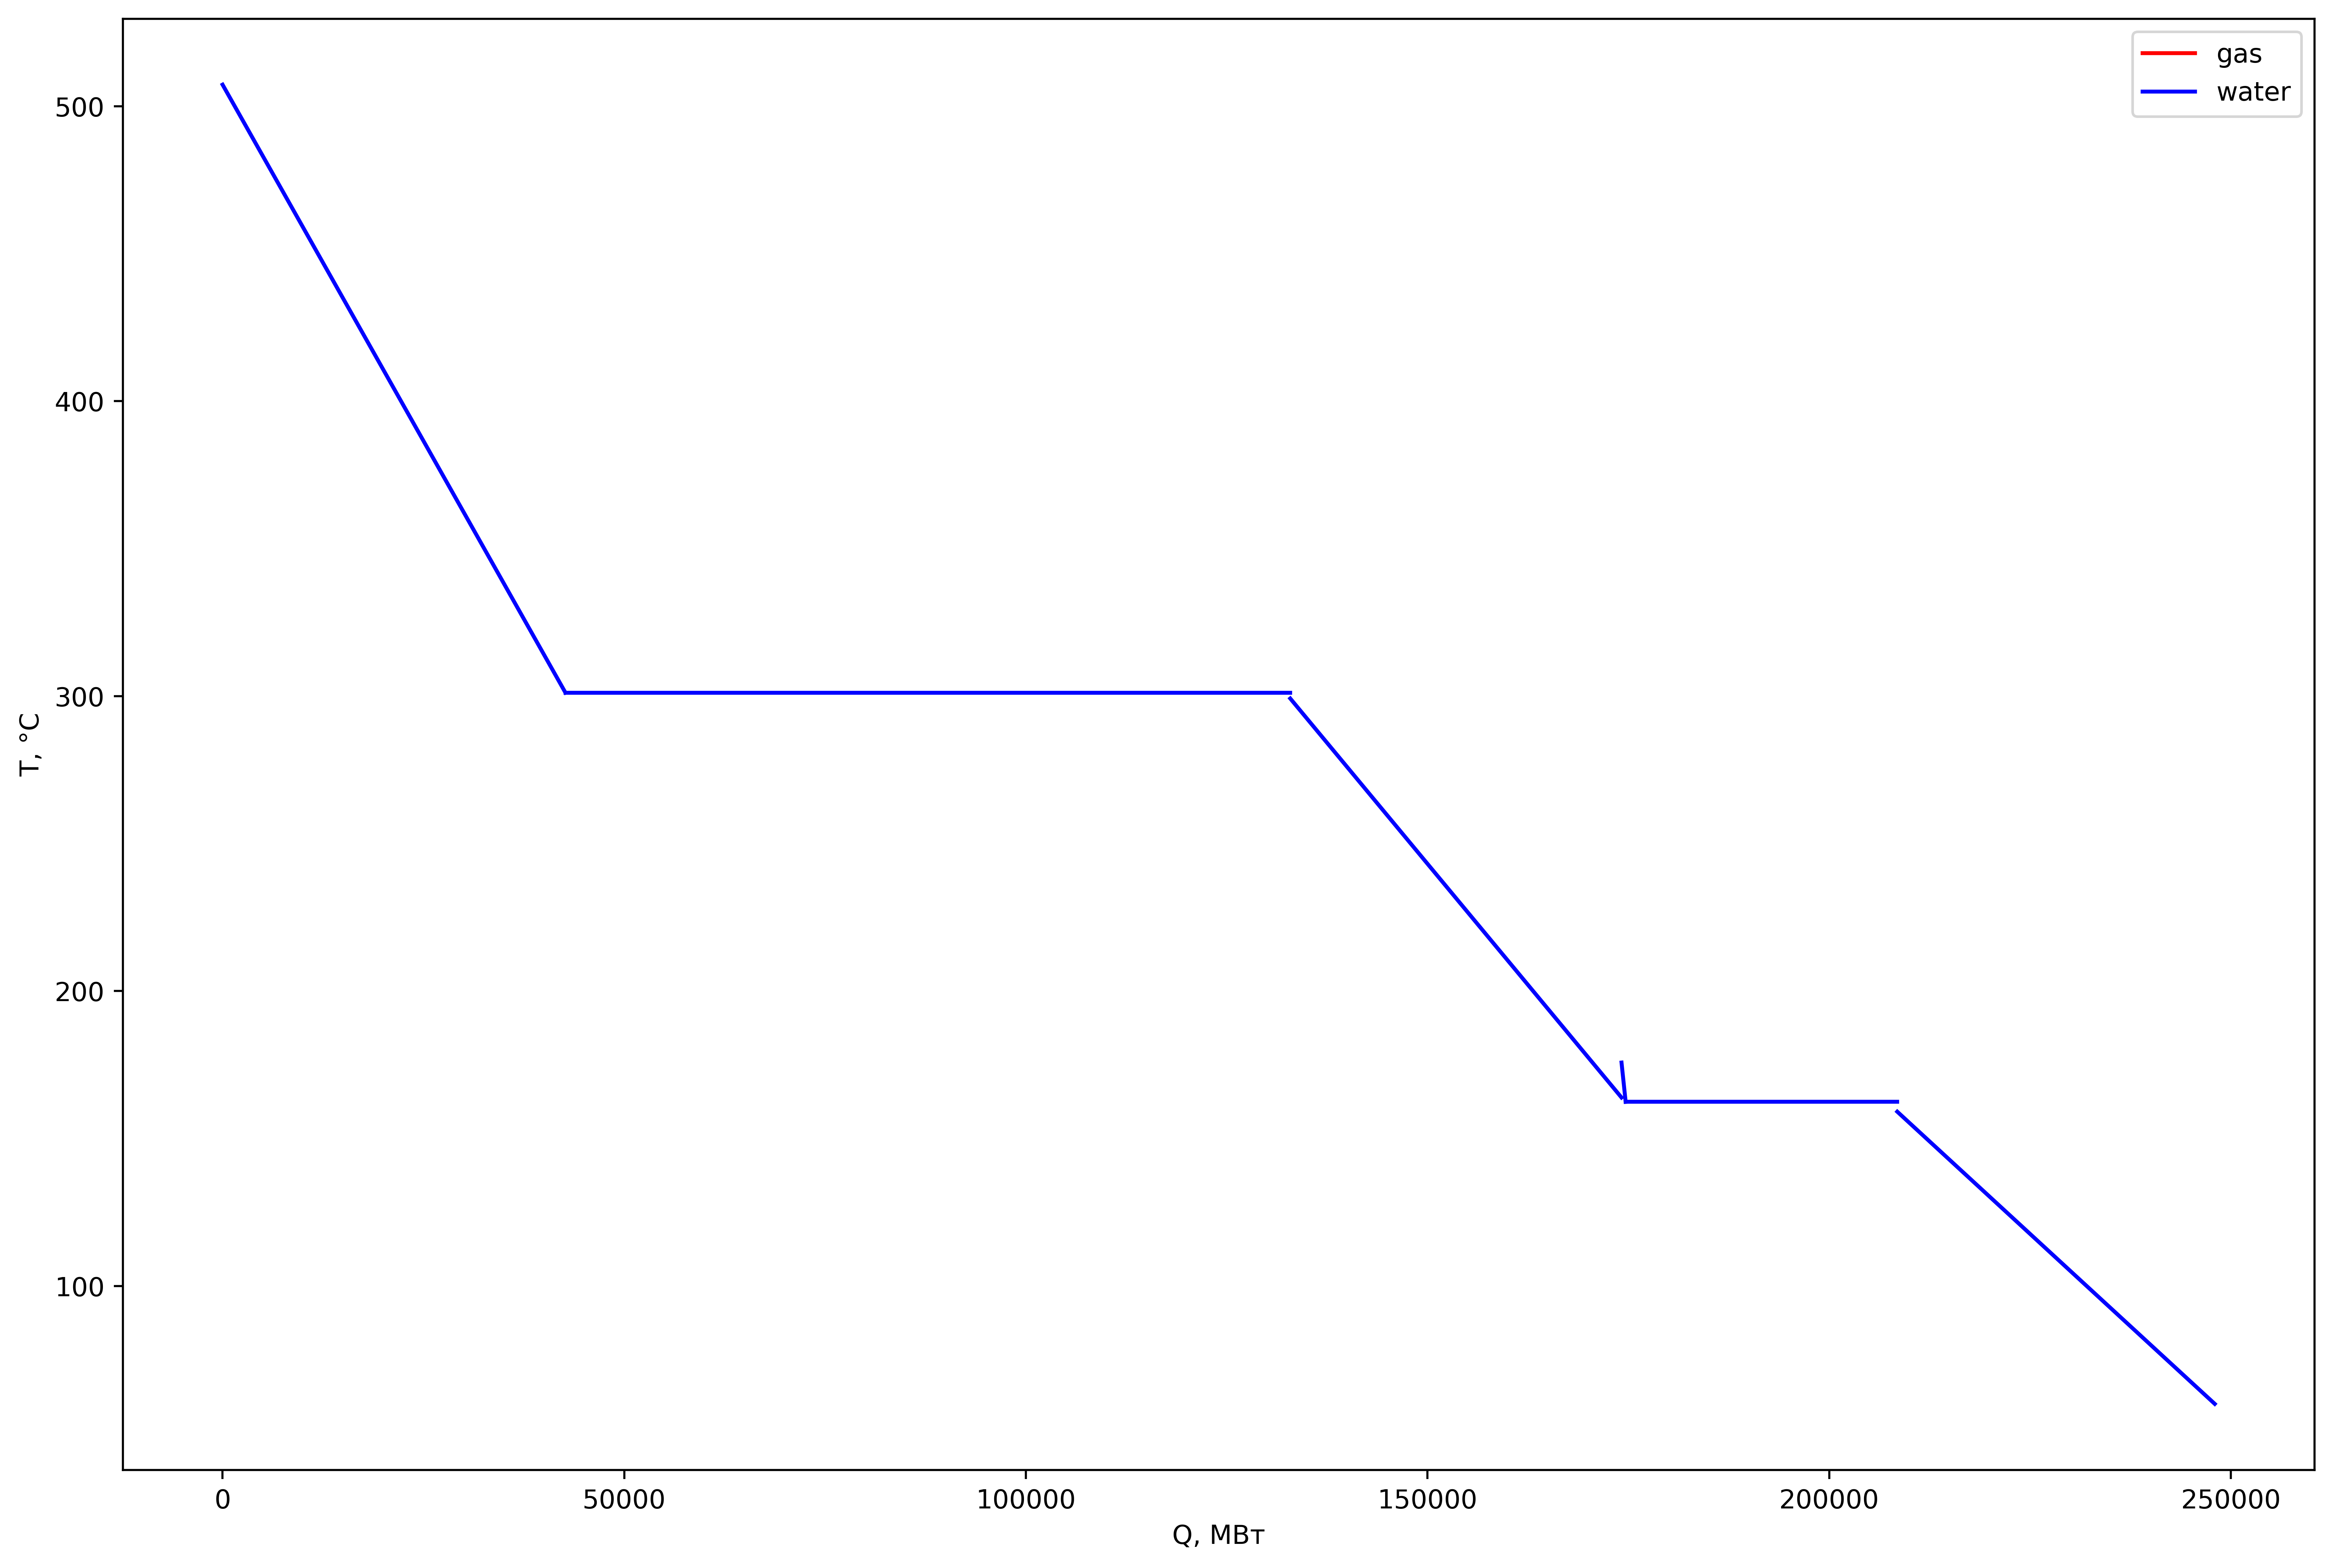

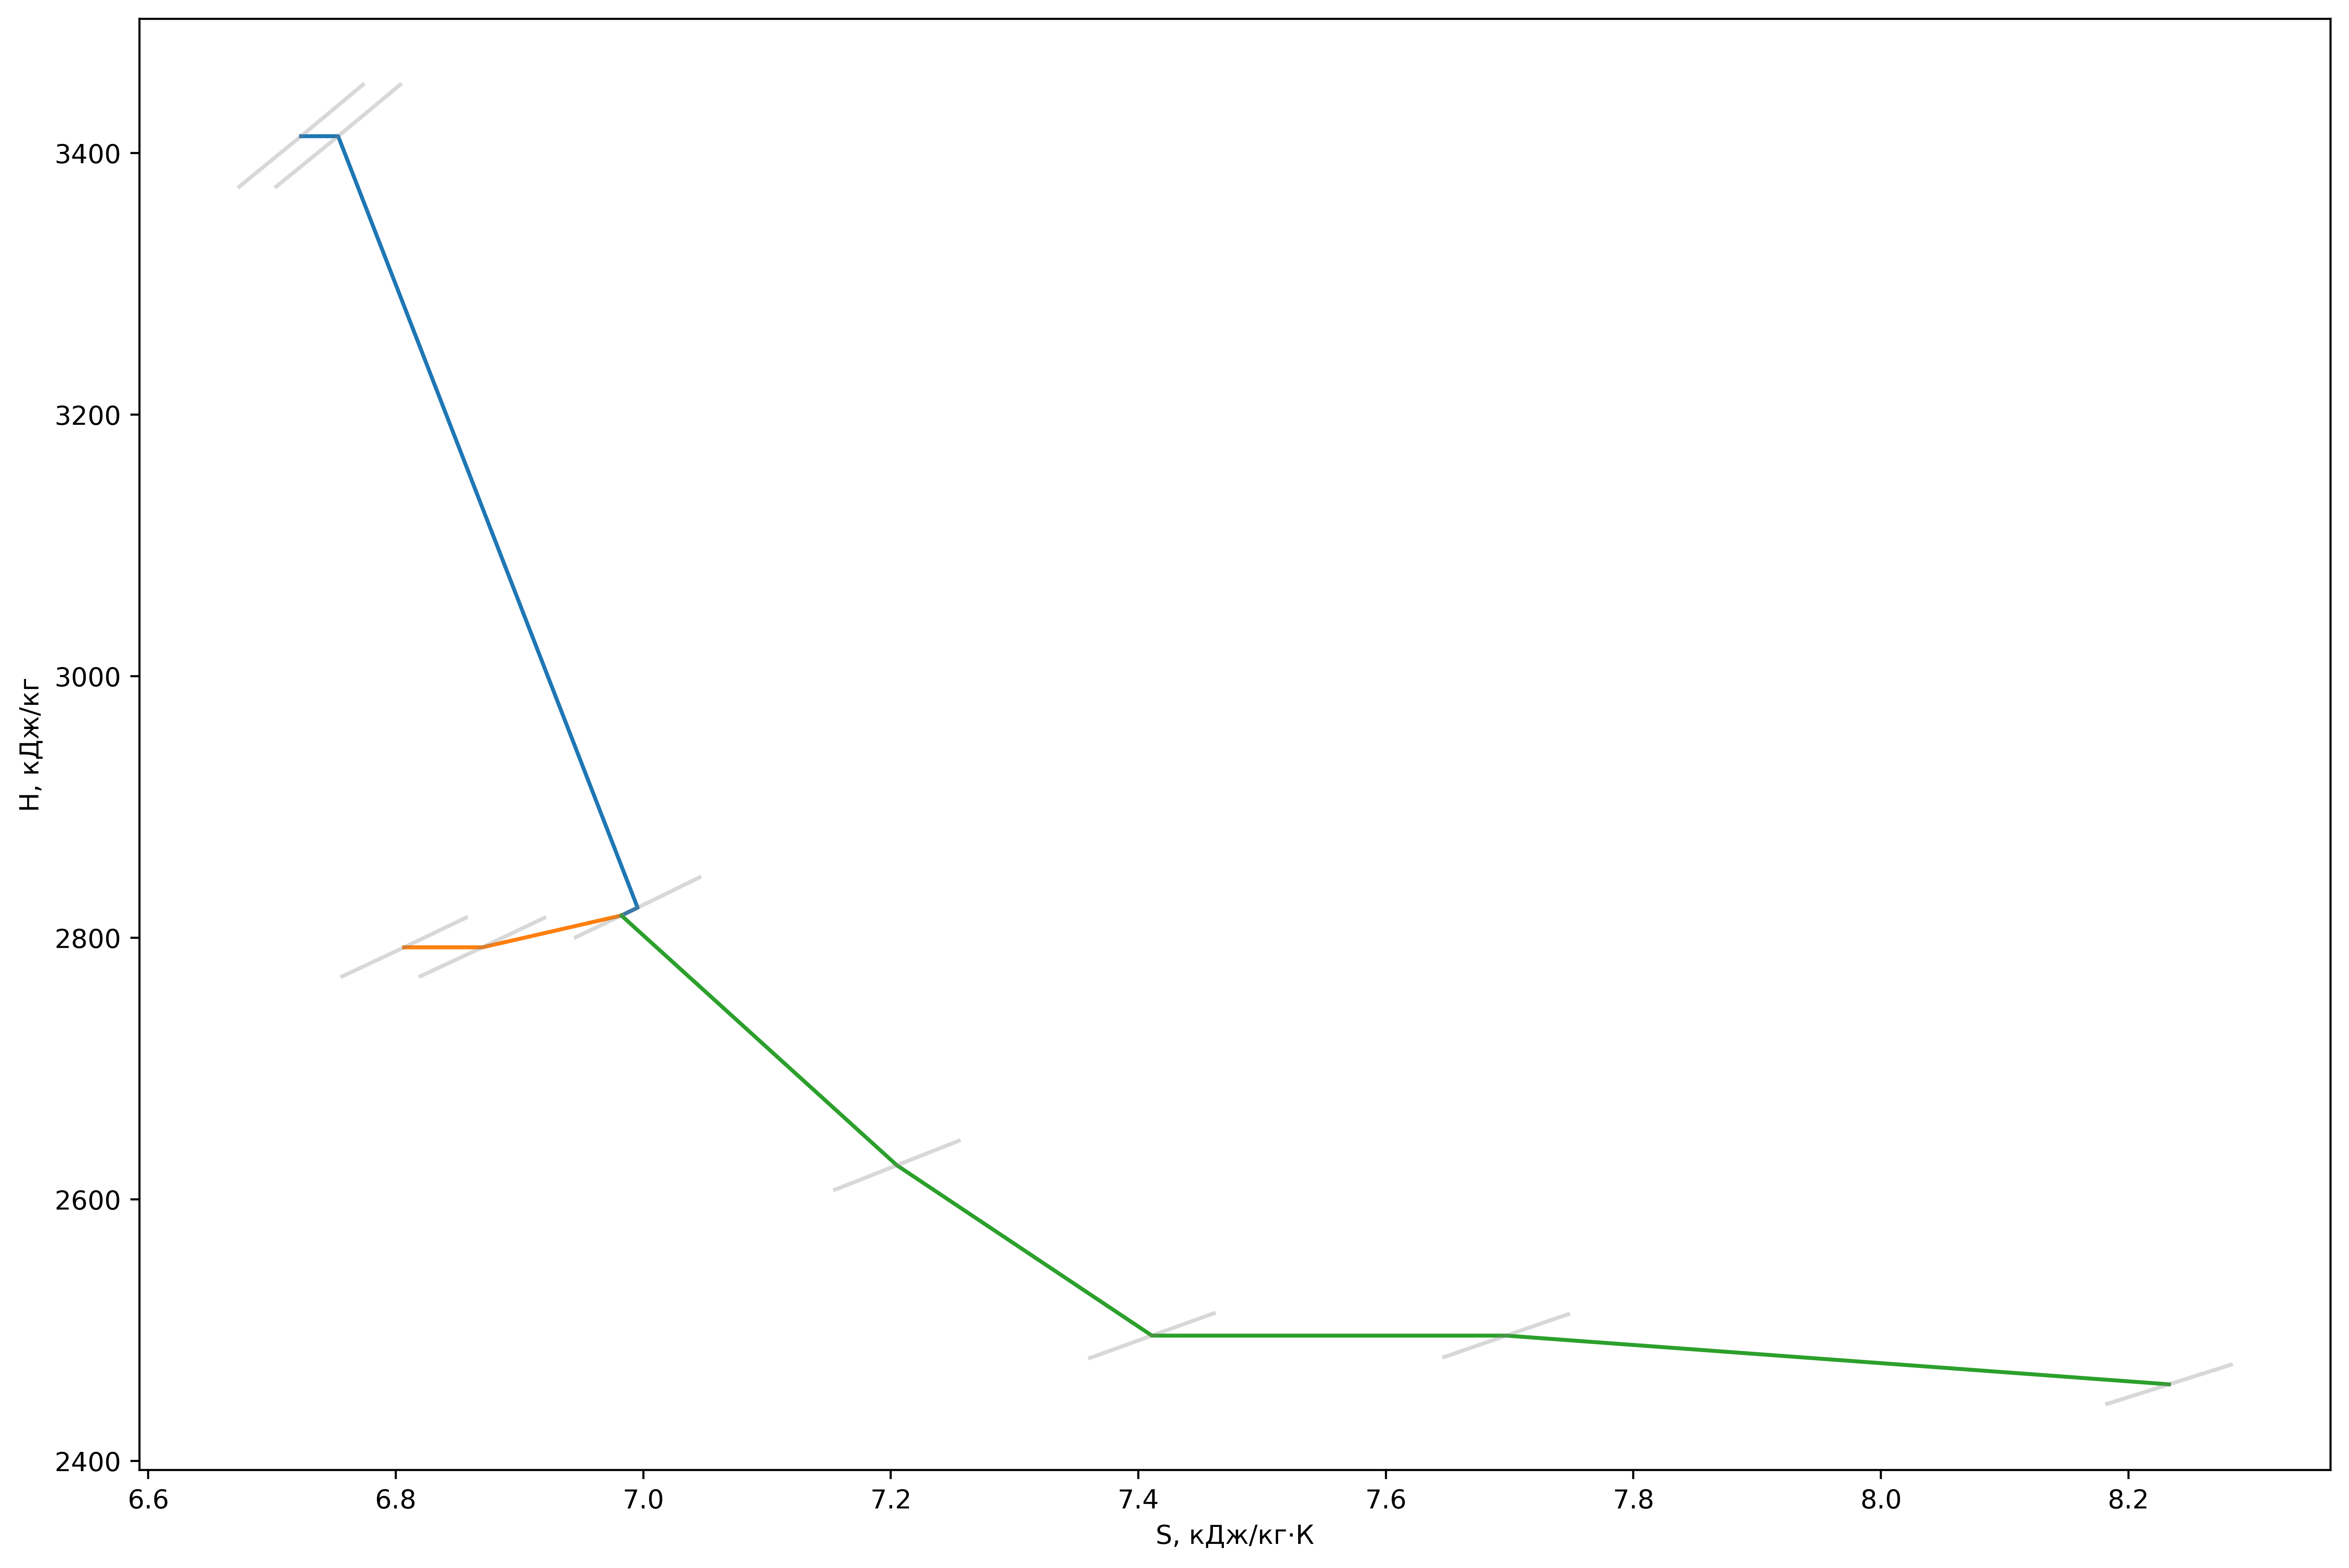

In [10]:
import Grafiki

Grafiki.Q_t_diagram(gas_streams, water_streams, heaters, 15, 10)
Grafiki.H_S_diagram(water, water_streams, 15, 10)

In [11]:
########################ОГРАНИЧЕНИЯ НА РАБОТУ ПГУ########################
# ЕСЛИ ТЕПЛОФИКАЦИЯ (из документов по ПГУ-220Т)
# Gк_мин=4,44 кг/с вроде
# Nтурбины мин = 17,6 МВт (примерно 25%)
# Максимальноа давление в отборах СП 0,245, 0,198 МПа (Теплофикационная паровая турбина Т-63/76-8.8 для серии ПГУ-230)
# ДЛЯ ВСЕХ РЕЖИМОВ (Из Трухния по ПГУ-450Т)
# Gвд_мин=25% от номинала
# Gнд_мин = 50% от номинала


GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)

Max_iterations_minimum = 10

if Сalculate_minimum == True:
    n_GTU = GTU_input.at["n", 1]
    start_time = time.time()
    for i in range(Max_iterations_minimum):
        print(f"Началась {i+1} итерация расчета ПГУ")
        if i < round(Max_iterations_minimum / 2, 1):
            New_iterations_KU_TU, New_iterations_cotel, New_iterations_turbine = (
                2,
                2,
                15,
            )
        else:
            New_iterations_KU_TU, New_iterations_cotel, New_iterations_turbine = (
                Maxiterations_KU_TU,
                Maxiterations_cotel,
                Maxiterations_turbine,
            )

        Delt_Gcnd = 100
        Delt_Nturb = 100
        if Teplo == 1:
            Delt_Gcnd = (water_streams.at["INKOND", "G"] - 4.44) / 4.44
            Delt_Nturb = (electric.at["Turbine", "Ni"] - 17.6) / 17.6
        Delt_Gvd = (
            water_streams.at["PEVD-DROSVD", "G"] / water_streams0.at["PEVD-DROSVD", "G"]
            - 0.25
        ) / 0.25
        Delt_Gnd = (
            water_streams.at["PPND-DROSND", "G"] / water_streams0.at["PPND-DROSND", "G"]
            - 0.5
        ) / 0.5
        Delta_min = min(Delt_Gcnd, Delt_Nturb, Delt_Gvd, Delt_Gnd)
        if n_GTU == 1 and Delta_min < 0:
            print("Мощность ГТУ 100% и расход пара все еще слишком мал")
        n_GTU = n_GTU - Delta_min / 10
        GTU_input.at["n", 1] = n_GTU

        calculate_CCGT(
            New_iterations_KU_TU, New_iterations_cotel, New_iterations_turbine
        )
        print(f"Отклонение от ограничения минимальное равно {Delta_min}")
        if abs(Delta_min) < Calctolerance:
            calculate_CCGT(
                New_iterations_KU_TU, New_iterations_cotel, New_iterations_turbine
            )
            print(f"Отклонение от ограничения минимальное равно {Delta_min}")
            print(f"Относительная мощность ГТУ равна {n_GTU}")
            print(
                f"fin минимальная мощность ПГУ:--- {round((time.time() - start_time), 1)} сек. ---"
            )
            break
        if i == Max_iterations_minimum - 1:
            print(
                "Достигнуто максимальное количество итераций минимального расхода в ПГУ",
                i + 1,
            )

Началась 1 итерация расчета ПГУ
Достигнуто максимальное количество итераций котла-утилизатора:2
Достигнуто максимальное количество итераций расхода КУ+ПТУ: 2
Время 1 итерации расчета КУ+ТУ:---  8.9 сек. ---
Достигнуто максимальное количество итераций котла-утилизатора:2
Достигнуто максимальное количество итераций давления верхнего отбора
Diafragma_it [0.020901996693974776, 0.02122834242858079, 0.021532392008744395, 0.021439826534196574]
Погрешность давления в верхнем сетевом отборе в %:  0.278
Достигнуто максимальное количество итераций давления верхнего отбора
Diafragma_it [0.022110090366288405, 0.022426688908782213, 0.022343778296996, 0.021973979096109424]
Погрешность давления в верхнем сетевом отборе в %:  1.109
Достигнуто максимальное количество итераций расхода КУ+ПТУ: 2
Время 2 итерации расчета КУ+ТУ:---  41.2 сек. ---
Достигнуто максимальное количество итераций давления КУ+ПТУ: 2
Pnd_it [0.65057, 0.67226, 0.64576]
Pvd_it [8.38712, 8.14902, 8.05482]
Max_error_P 7.882615194947951
